In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lista 12 cz. 2. (5 pkt.)

## Zadanie 1 (3 pkt.)

NTRUEncrypt jest zdefiniowany za pomocą trzech paramterów $N$, $p$, $q$ $\in\mathbb{N}$. Gdzie $q>p$, $NWD(p,q)=1$, $p$ jest nieparzyste. Popularnym wyborem są $p=3$, $q=2048$, natomiast $N$ zwykle jest liczbą pierwszą, obecnie zalecana wartość to $N=401$. W dalszych zadaniach będziemy korzystać z tych wartości, o ile nie będzie napisane inaczej. Obliczenia są wykonywane w pierścieniu $\mathcal{R}=\mathbb{Z}\left[x\right]/\left(x^N-1\right)$ są to wielomiany o współczynikach całkowitych modulo wielomian $x^N-1$. Mnożenie w tym pierścieniu jest proste, zwyczajnie mnożymy wielomiany a następnie liczymy resztę z dzielenia przez $x^N-1$.

Można to też zrobić jeszcze prościej mianowicie po wymnożeniu wielomianów każdy wykładnik $x$ zmieniamy na resztę z dzielenia przez $N$, np.:

$$(x^2+3x+1)(2x^2+x-4)=2x^4+7x^3+x^2-11x-4=2x+7+x^2-11x-4=x^2-9x+3$$

Najwygodniej jest reprezentować te wielomiany jako wektory współczynników
$$a(x)=\sum_{i=0}^{N-1}a_ix^i\equiv \vec{a}=(a_0,a_1,...,a_{N-1})$$
np.:
$$x^2+3x+1\equiv (1,3,1)$$
$$2x^2+x-4\equiv (-4,1,2)$$
wtedy mnożenie dwóch wielomianów można zapisać jako **splot**:
$$c(x)=a(x)b(x)$$
$$\vec{c}=\vec{a}\star\vec{b}$$
$$c_i=\sum_{j=0}^{N-1}a_jb_{i-j}$$
gdzie wszystkie indeksy są brane modulo $N$.

Uwaga: mnożenie wielomianów zawsze można zapisać jako splot. Tutaj dzielenie wielomianu przez $x^N-1$ jest ukryte w braniu indeksów modulo $N$.

Zaimplementuj działanie $\star$, czyli mnożenie wielomianów w pierścieniu $\mathcal{R}$ (funkcja **multiply_R**). Możesz to zrobić zarówno za pomocą splotu jak i mnożąc wielomianu i biorąc resztę z dzielenia przez $x^N-1$.

We wszystkich zadaniach możesz korzystać z gotowych funkcji do mnożenia i dzielenia wielomianów.

Uwaga: nie zawsze będzie to możliwe wprost, patrz treści zadań

In [2]:
from numpy.polynomial.polynomial import polymul, polydiv, polyadd, polysub

Poniżej jest pomocnicza funkcja, która zwraca wielomian $x^N-1$ dla podanego $N$, możesz jej użyć w dalszych implementacjach.

In [3]:
def poly_N(N):
    return [-1]+(N-1)*[0]+[1]

Na tej liście przyjmujemy konwencję, że wielomian jest reprezentowane przez listę współczynników w kolejności od współczynnika przy $x^0$ oraz że zera na końcu listy mogą być pominięte ale nie muszą tzn.:

$$x^3+2x-3\equiv [-3,2,0,1]\equiv [-3,2,0,1,0]\equiv [-3,2,0,1,0,0,0,0,0,0]$$

Uważaj na zera na końcu przy porównywaniu wielomianów.

poniżej $a$, $b$ to wielomiany, które mnożymy, $N$ definiuje pierścień $\mathcal{R}$.

In [4]:
def multiply_R(a,b,N):
    poly = poly_N(N)
    a += [0] * (N - len(a))
    b += [0] * (N - len(b))
    
    mul = polymul(a, b)
    _, c = polydiv(mul, poly) 
#     print(c)
    return c

In [5]:
print(multiply_R([1,3,1],[-4,1,2],3)==[3, -9, 1])
print(multiply_R([-7,5,1,0,2],[0,6,-1,0,2],5)==[22, -42, 37, 5, -15])
print(multiply_R([1,2,3],[3,0,8,9,-1,2],6)==[4, 12, 17, 25, 41, 27])
print(multiply_R([0,1,5],[2,4],5)==[0, 2, 14, 20])
print(multiply_R([7,1,-1,0],[0,1,0,0,0],6)==[0, 7, 1, -1])

[ True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True  True]
[ True  True  True  True]
[ True  True  True  True]


Przy wykonywaniu działań w ramach NTRUEncrypt będziemy potrzebowali nieco zmodyfikowanej wersji operacji modulo. Operacja **mods** jest zdefiniowana następująco:
$$a\quad mods\quad n = b \Longleftrightarrow a\equiv b \mod n \land-\frac{n-1}{2}\leq b\leq \frac{n}{2}$$
np.:
$$a\quad mods \quad 5\in \{-2,-1,0,1,2\}$$
natomiast
$$a\quad mod \quad 5\in \{0,1,2,3,4\}$$
Czyli jest to operacja modulo ale zwracająca wartości symetryczne wokół zera.

Zaimplementuj **mods**.

In [6]:
def mods(a,n):
    rad = int((n-1) / 2)
    vals = [i for i in range(-rad, rad+1)]
    mod = int((a+rad)%n)
    result = vals[mod]
#     print(vals, mod, result)
    return result

In [8]:
print(mods(7,3)==1)
print(mods(8,3)==-1)
print(mods(7,5)==2)
print(mods(8,5)==-2)
print(mods(9,5)==-1)

True
True
True
True
True


Teraz wygenerujemy klucze publiczny i prywatny.

Niech $F(x)$, $G(x)$ $\in\mathcal{R}$ będą tajnymi wielomianami, ze współczynnikami pochodzącymi ze zbioru $\{-1,0,1\}$. Następnie defniujemy:
$$f(x)=1+pF(x)$$
$$g(x)=pG(x)$$
$$h(x)=f^{-1}(x)g(x)\quad mods\quad q$$
gdzie $f^{-1}(x)$ to odwrotność $f$ w pierścieniu $\mathcal{R}$ mods $q$.

Wtedy klucz publiczny to wektor współczynnikó $\vec{h}$ a klucz prywatny to $\vec{f}$

Aby wykonać powyższe obliczenia musimy napisać funkcję odwracającą wielomian w pierścieniu $\mathcal{R}$ ale traktując jego współczynniki jako pochodzące z ciała $\mathbb{Z}_q$. Robimy to za pomocą Rozszerzonego Algorytmu Euklides (jak kiedyś dla ciał Galois) ale potrzebujemy odpowiednich funkcji dzielących i mnożących. Musimy zdefiniować funkcję mnożącą wielomiany ze współczynnikami z ciała $\mathbb{Z}_q$ ale **nie** dzielącą przez $x^N-1$. Możemy tu użyć gotowej funkcji **polymul** z biblioteki a następnie wziąć współczynniki **mods** $q$ (**nie** mod !).

In [9]:
def multiply_q(a,b,q):
    mul = polymul(a, b)
#     print(mul)
    result = [mods(int(i), q) for i in mul]
    return result

In [10]:
print(multiply_q([-1,0,5,3],[1,0,0,9,-3],31)==[-1, 0, 5, -6, 3, 14, 12, -9])
print(multiply_q([0,6,0,1,1,1],[0,7,2,1,0],11)==[0, 0, -2, 1, 2, -2, -1, 3, 1])

True
True


Teraz musimy zaimplementować fukcję dzielącą wielomiany mods $q$. Tutaj **Nie** możemy użyć gotowej funkcji **polydiv** ponieważ traktuje ona współczynniki wielomianów jakby pochodziły z ciała $\mathbb{R}$ a u nas pochodzą z ciałą $\mathbb{Z}_q$. O ile przy mnożeniu wystarczy wziąć wynik mods $q$ i nie ma problemu o tyle przy dzieleniu to się nie uda. Np.: dla $5\in\mathbb{R}$ mamy $5^{-1}=0.2\notin\mathbb{Z}$ a dla $5\in\mathbb{Z}_7$ mamy $5^{-1}=3\in\mathbb{Z}_7$. Zatem musimy zaimplementować dzielenie samodzielnie. Najpierw zaimplemtujmy funkcję do odwracania liczb w ciele $\mathbb{Z}_q$ (cały czas pamiętaj o **mods**):

In [11]:
def inv_q(a,q):
    result = None
    for i in range(q):
        mod = mods(a*i, q)
        if mod==1:
            result = i #odwrotnosc modularna
            break
           
    return result

In [12]:
print(inv_q(5,7)==3)
print(inv_q(5,7)==3)
print(inv_q(-5,31)==6)

True
True
True


Poniżej są pomocnicze funkcje, które możesz wykorzystać.

Sprawdzanie czy wielomian jest wielomianem zerowym:

In [13]:
def is_zero(a):
    return np.all([_ == 0 for _ in a])

Stopień wielomianu:

In [14]:
def deg(a):
    if is_zero(a):
        return 0
    else:
        return np.nonzero(a)[0][-1]

Współczynnik przy najwyższej potędze:

In [15]:
def lead(a):
    return a[deg(a)]

Teraz korzystając z **inv_q** oraz **multiply_q** (do dodawania i odejmowania wielomianów można użyć zwykłych **polyadd** i **polysub** biorąc współczynniki **mods** $q$)

In [16]:
def add_q(a,b,q):
    add = polyadd(a, b)
#     print(mul)
    result = [mods(int(i), q) for i in add]
    return result

def sub_q(a,b,q):
    sub = polysub(a, b)
    
    result = [mods(int(i), q) for i in sub]
    return result

In [17]:
def find_multiple_of(a,q,w):
    result = None
#     print("range", -int((q-1) / 2), int((q-1) / 2)+1, "q=", q)
    for i in range(-int((q-1) / 2), int((q-1) / 2)+1):
        mod = mods(a*i, q)
#         print("a=",a, "i=",i, a*i, "mod=", mod, "szukana",w)
        if mod==w:
            result = i #odwrotnosc modularna
            break
    
    if(result == None):
        print("nie znalazlem")
        
    return int(result)

In [18]:
def divide_q(a,b,q):
    while b[-1]==0:
        b = b.pop() #wywalenie niepotrzebnych 0 z konca listy
    a += [0] * (len(b) - len(a)) #uzupelnienie stopnia wielomianu

    result = []
    a_rev = a[::-1]
    for _ in range(len(a)-len(b)+1):
#         print("a=", len(a), a)
        result_i = find_multiple_of(b[-1], q, mods(a[-1],q)) #jaka liczba pomnozona przez b[-1] da a[-1] w ciele Zq
        result.insert(0,result_i)
        to_sub = [mods(result_i*i, q) for i in b] #oblicz wielomian do odjecia od a
#         print("to_sub",to_sub)

        rest = sub_q(a[-len(to_sub):], to_sub, q) #nowe a lub reszta z dzielenia
        new_a = rest
#         print("new a", len(new_a), new_a)
        while len(to_sub)-1 > len(new_a):
            new_a.append(0)
        a = a[:-1] #wywalam najwyzszy stopien
        a = a[:-len(new_a)] + new_a
        
        
    while rest[-1]==0 and len(rest)>1: #wywalenie 0 przy najwyższych stopniach
        rest = rest[:-1]
        
#     print(result, rest)    
    return (result, rest)    

In [19]:
print(divide_q([1,7,0,-2,5],[0,4,1,-4],11)==([5, -4], [1, -2]))
print(divide_q([0,1,-1,0,1],[1,1,1],7)==([-1, -1, 1], [1, 3]))
print(divide_q([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],poly_N(23),31)==([0], [1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3]))
print(divide_q(poly_N(23),[1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],31)==([0, 0, 0, 0, 0, -10], [-1, 0, 0, 0, 0, 10, 0, 1, 0, 1, 0, 0, 0, -1, 1]))

True
True
True
True


Teraz korzystając z funkcji **divide_q** i **multiply_q** oraz Rozszerzonego Algorytmu Euklidesa możemy zaimplementować odwrotność w pierścieniu $\mathcal{R}$ mods $q$.

Uwaga: $NWD(a(x),x^N-1)$ może być dowolną liczbą całkowitą i to jest równoważne sytuacji gdyby było równe $1$ ale trzeba znalezioną odwrotność podzielić (tj. pomnożyć przez odwrotność w ciele $\mathbb{Z}_q$) przez tę liczbę. Tzn. jeżeli $NWD(a(x),x^N-1)=c$, co znajdziemy w Rozszerzonym Algorytmie Euklidesa jako ostatnią niezerową resztę z dzielenia, to wtedy szukana odwrotnoś $a^{-1}(x)$ będzie wielomianem zwróconym przez algorytm razy $c^{-1}$.

In [20]:
def gcdExtended_q(a, b, q):
#     https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm
    # Base Case
    if deg(a) < deg(b):
        temp = a
        a = b
        b = temp
    
#     print("a i b", a,b)
    if is_zero(b):
#         print(a[0])
        return a, 0, 1
    
    div, rest = divide_q(a, b, q)
#     print("div i rest", div, rest, "\n")
    gcd,x1,y1 = gcdExtended_q(b, rest, q)
    
    x = sub_q(y1, multiply_q(div,x1, q), q)
    y = x1
        
    return gcd,x,y

In [21]:
def inv(a,N,q):
    poly = poly_N(N)
    a = [mods(i, q) for i in a]
    c, x, y = gcdExtended_q(a, poly, q)
    c_1 = inv_q(c[0], q) #odwrotnosc 1 w polu q
#     print(c_1)
    
    x_inv = [mods(int(i)*c_1, q) for i in x]
    y_inv = [mods(int(i)*c_1, q) for i in y]
    
#     print(x_inv)
#     print(y_inv)
    
    result = x_inv
    
    return result

In [22]:
print(inv([1,5,-2,3],4,5)==[-1, 1, -2])
print(inv([1,5,-2,3],5,5)==[0, -2, 1, 1, -2])
# print(inv([1,5,-2,3],4,7)==[-2, -2, -1])
print(inv([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],23,31)==[-4,4,-10,15,-5,12, 5, 15,-11, 13,-12, 5,-1, 1, -6, 12, -9,-13, 11, -4, -8, -9, 14])

True
True
True
True


Na koniec potrzebujemy jeszcze funkcji **multiply_R_q** liczącej iloczyn w $\mathcal{R}$ mods $q$, tutaj wystarczy użyć funkcji **multiply_R** i wziąć współczynniki mods $q$.

In [23]:
def multiply_R_q(a,b,N,q):
    mul = multiply_R(a, b, N)
    result = [mods(i, q) for i in mul]
    return result

In [24]:
print(multiply_R_q([1,3,1],[-4,1,2],3,31)==[3, -9, 1])
print(multiply_R_q([-7,5,1,0,2],[0,6,-1,0,2],5,31)==[-9, -11, 6, 5, -15])
print(multiply_R_q([1,2,3],[3,0,8,9,-1,2],6,11)==[4, 1, -5, 3, -3, 5])

True
True
True


Teraz wreszcie możemy zaimplemtować funkcję generującą klucze publiczny i prywatny dla danych (tajnych) wielomianów $F$ i $G$.
$$f(x)=1+pF(x)$$
$$g(x)=pG(x)$$
$$h(x)=f^{-1}(x)g(x)\quad mods\quad q$$
$h$ to klucz publiczny a $f$ prywatny.

Funkcja **key_gen** ma zwracać parę klucz prywatny i publiczny.

In [25]:
def key_gen(F,G,N,q,p):
    pF = multiply_q(p, F, q)
    f = add_q([1], pF, q) #ok
        
    g = multiply_q(p, G, q)
    
    f_1 = inv(f, N, q)
    h = multiply_R_q(f_1, g, N, q)
    
    return f, h

Dalej będziemy używać poniższych parametrów:

In [26]:
F = [0,0,-1,0,-1,0,0,0,1,-1,0,0,0,0,0,0,0,0,1,0,0,0,0]
G = [0,-1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0]
N=23
q=31
p=3

In [27]:
print(key_gen(F,G,N,q,p)==([1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3],[8, 1, 4, 0, 0, -8, 5, 10, 3, -14, -5, 7, -3, 14, -6, -14, 8, 0, -14, 12, 0, -15, -13]))

True


Teraz możemy zaimplemetować operację szyfracji. Wielomian $m$ reprezentuje wiadomość natomiast wielomian $r$ to losowo wybrany wielomian $\vec{r}\in\{-1,0,1\}^N$. Wtedy szyfrogram to:
$$\vec{y} = \vec{r}\star\vec{h}+\vec{m}\quad mods \quad q$$
$\star$ to mnożenie w pierścieniu $\mathcal{R}$.

In [28]:
def encrypt(m,h,r,N,q):
    rh = multiply_R_q(r, h, N, q)
    y = add_q(rh, m, q)
    return y

In [29]:
m = [-1,0,0,0,0,0,0,1,0,0,0,0,-1,0,0,1]
r = [0,0,-1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1]

f, h = key_gen(F,G,N,q,p)

print(encrypt(m,h,r,N,q)==[-3, -15, -5, -14, 15,-10, 15, -14, 12, -9, -1, -7, -10, 3, -8, 8, 6, -15, 10, 8, 4, -15, 5])

True


In [30]:
print(f)

[1, 0, -3, 0, -3, 0, 0, 0, 3, -3, 0, 0, 0, 0, 0, 0, 0, 0, 3]


Oraz operację deszyfracji:
$$\vec{m}=(\vec{f}\star\vec{y}\quad mods\quad q)\quad mods \quad p$$

In [31]:
def decrypt(y,f,N,q,p):
    fy = multiply_R_q(f, y, N, q)
#     print("fy=",fy)
    m = [mods(i, p) for i in fy]
#     print("m", m, len(m))
    
    while m[-1]==0 and len(m)>1: #wywalenie 0 przy najwyższych stopniach
        m = m[:-1]
        
    return m

In [32]:
print(decrypt(encrypt(m,h,r,N,q),f,N,q,p)==m)

True


## Zadanie 2 (1 pkt)

Łamanie szyfru NTRUEncrypt można sprowadzić do problemu szukania niezerowego wektora o najmniejszej normie lub szukania wektora najbliższego do danego na **kracie**. Kratą nazywamy zbiór wektorów o wspólczynnikach całkowitych rozpiętych na pewnej bazie wektorów $v_i\in\mathbb{Z}^k$. Aby zobaczyć dlaczego te problemy mogą być równoważne policz średnią normę wektora $(\vec{f},\vec{g})$ dla losowo wybranych (wielu np. 1000) $F$ i $G$, pamiętaj że $F$ i $G$ maja współczynniki ze zbioru $\{-1,0,1\}$. Potraktuj wektor $(\vec{f},\vec{g})$ jako zlepek dwóch wektorów $(f_0,...,f_{N-1},g_0,...,g_{N-1})$.

In [33]:
q = 2048
p = 3
N = 401

In [34]:
norms = []
for _ in range(1000):
    f = np.random.randint(low=-1, high=2, size=(N,)) # {-1, 0, 1}
    g = np.random.randint(low=-1, high=2, size=(N,)) # {-1, 0, 1}
    
    vector = np.concatenate((f, g)) # (𝑓0,...,𝑓𝑁−1,𝑔0,...,𝑔𝑁−1)
    norm = np.linalg.norm(vector)
    norms.append(norm)
    
avg = np.average(norms)
print(avg)

23.129083167630252


In [35]:
# norms = []
# for _ in range(1000):
#     F = list(np.random.randint(low=-1, high=2, size=(N,))) # {-1, 0, 1}
#     G = list(np.random.randint(low=-1, high=2, size=(N,))) # {-1, 0, 1}
    
#     pF = multiply_q(p, F, q)
#     f = np.array(add_q([1], pF, q))
#     g = np.array(multiply_q(p, G, q))
    
#     vector = np.concatenate((f, g)) # (𝑓0,...,𝑓𝑁−1,𝑔0,...,𝑔𝑁−1)
#     norm = np.linalg.norm(vector)
#     norms.append(norm)
    
# avg = np.average(norms)
# print(avg)

A teraz policz normę losowo wybranych wektorów o długości $2N$ ze współczynnikami z przedziału $[-q/2,q/2]$. Która jest znacznie większa?

In [36]:
norms = []
N = 2*N
rang = q/2
for _ in range(1000):
    f = np.random.randint(low=-rang, high=rang+1, size=(N,)) # [−𝑞/2,𝑞/2]
    g = np.random.randint(low=-rang, high=rang+1, size=(N,)) # [−𝑞/2,𝑞/2]
    
    vector = np.concatenate((f, g)) # (𝑓0,...,𝑓𝑁−1,𝑔0,...,𝑔𝑁−1)
    norm = np.linalg.norm(vector)
    norms.append(norm)
    
avg = np.average(norms)
print(avg)

23672.805570334658


## Zadanie 3 (1 pkt)

Narysuj kraty o bazach:

a) $\{(0,1),(2,0)\}$

b)$\{(1,7),(2,12)\}$

Tzn. ich fragmenty bo są oczywiście nieskończone. Poniżej przykład kraty dla bazy $\{(1,1),(1,-1)\}$.

<img src="krata.png" width="1000" align="left"/>


<function matplotlib.pyplot.show(*args, **kw)>

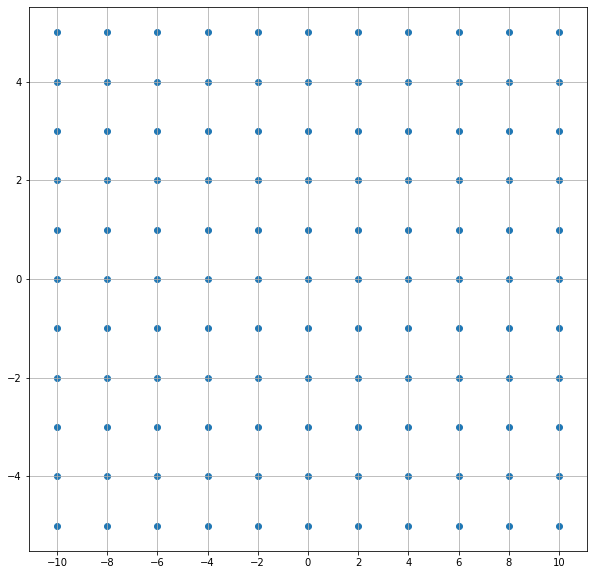

In [63]:
x=[]
y=[]
for c in range(-5, 6):
    for z in range(-5, 6):
        x.append(2*c)
        y.append(z)
        
plt.figure(figsize=(10, 10))
plt.grid()
plt.xticks(np.arange(min(x), max(x)+1, 2))
plt.scatter(x, y)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

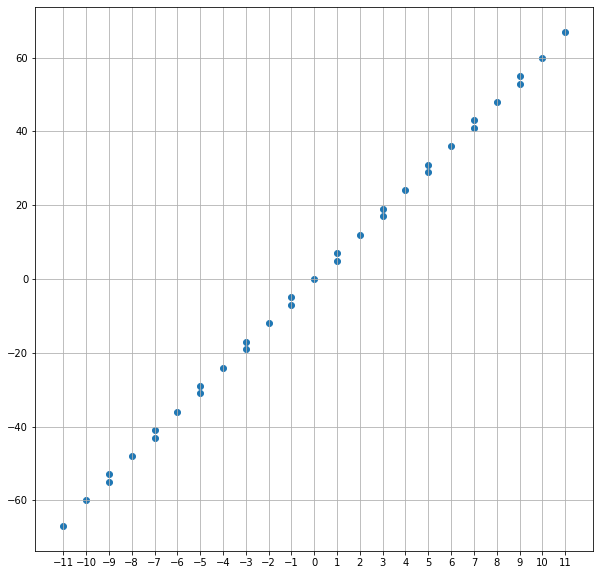

In [57]:
x=[]
y=[]
for c in range(-1,2):
    for z in range(-5, 6):
        x.append(c + (2*z))
        y.append((7*c) + (12*z))
        
plt.figure(figsize=(10, 10))
plt.grid()
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.scatter(x, y)
plt.show